In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from assign_kr_type import assign_core_kr_type

In [16]:
import pandas as pd
import re

def assign_kr_type_for_merge(annotation_string):
    """
    Parses an annotation string from the XiangDB to find an explicit KR type
    and converts it to the ClusterCAD format based on specific mapping rules.
    
    - Converts specific subtypes (e.g., A1KR -> A1).
    - Converts '0-level' subtypes (e.g., A0KR -> A).
    - Converts general types (e.g., AKR -> A).
    - Classifies all other annotations as 'U' (Unpredictable).
    """
    if pd.isna(annotation_string):
        return "U"
    
    annotation_string = str(annotation_string)

    # Mapping from XiangDB notation to ClusterCAD notation.
    # The order of this dictionary is important to check for more specific
    # types (like A1KR) before general types (like AKR).
    type_mapping = {
        "A1KR": "A1", "A2KR": "A2",
        "B1KR": "B1", "B2KR": "B2",
        "C1KR": "C1", "C2KR": "C2",
        "A0KR": "A",
        "B0KR": "B",
        "C0KR": "C",
        "AKR": "A",
        "BKR": "B",
        "CKR": "C"
    }

    for xiang_type, cad_type in type_mapping.items():
        # Use regex word boundary (\b) to ensure we match the whole type
        # (e.g., prevent the pattern 'AKR' from matching inside 'A1KR').
        if re.search(r'\b' + xiang_type + r'\b', annotation_string):
            return cad_type

    # If no explicit KR type from the mapping is found, it's unpredictable.
    return "U"

# --- Main script execution block ---
print("--- Merging ClusterCAD and Xiang Datasets with Corrected Type Conversion ---")

# 1. Define hardcoded file paths
clustercad_file = "clustercad_kr_db.csv"
xiang_file = "xiang_kr_db.xlsx"
output_file = "db_merged.csv"

try:
    # 2. Load and process the main ClusterCAD dataset
    print(f"Loading ClusterCAD data from '{clustercad_file}'...")
    df_cad = pd.read_csv(clustercad_file)
    df_cad['source'] = 'ClusterCAD'
    print(f"Loaded {len(df_cad)} entries from ClusterCAD.")

    # 3. Load and process the new Xiang dataset
    print(f"Loading Xiang et al. data from '{xiang_file}'...")
    df_xiang_raw = pd.read_excel(xiang_file)
    df_xiang_raw['source'] = 'XiangDB'
    print(f"Loaded {len(df_xiang_raw)} entries from XiangDB.")

    # 4. Harmonize the Xiang dataset to match ClusterCAD's structure
    print("Processing and harmonizing XiangDB columns with precise KR type mapping...")
    df_xiang_processed = pd.DataFrame()

    # Map columns and apply processing
    df_xiang_processed['pks_name'] = df_xiang_raw['BGC code in MIBiG or name of product']
    df_xiang_processed['subunit_name'] = df_xiang_raw['Name of protein']
    df_xiang_processed['module_number'] = df_xiang_raw['Order of module'].str.extract(r'(\d+)', expand=False).astype(float)
    df_xiang_processed['kr_sequence'] = df_xiang_raw['Sequence']
    df_xiang_processed['kr_type_annotation'] = df_xiang_raw['Annotation'].apply(assign_kr_type_for_merge)
    df_xiang_processed['source'] = df_xiang_raw['source']
    
    # Add columns that exist in ClusterCAD but not XiangDB, filling with null values
    for col in df_cad.columns:
        if col not in df_xiang_processed.columns:
            df_xiang_processed[col] = pd.NA

    # 5. Concatenate the two dataframes
    print("Concatenating the two datasets...")
    # Ensure both dataframes have columns in the same order before concatenating
    final_columns = df_cad.columns
    df_merged = pd.concat([df_cad[final_columns], df_xiang_processed[final_columns]], ignore_index=True)

    # 6. Save the final merged dataframe
    df_merged.to_csv(output_file, index=False)
    print(f"\n✅ Merge complete. Final dataset has {len(df_merged)} total entries.")
    print(f"Output saved to '{output_file}'")
    
    # 7. Paste the output to the console as requested
    print("\n--- Final Merged Database (Preview) ---")
    print(df_merged)

except FileNotFoundError as e:
    print(f"\nError: File not found. Please make sure '{e.filename}' is in the correct directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Merging ClusterCAD and Xiang Datasets with Corrected Type Conversion ---
Loading ClusterCAD data from 'clustercad_kr_db.csv'...
Loaded 1481 entries from ClusterCAD.
Loading Xiang et al. data from 'xiang_kr_db.xlsx'...
Loaded 1762 entries from XiangDB.
Processing and harmonizing XiangDB columns with precise KR type mapping...
Concatenating the two datasets...

✅ Merge complete. Final dataset has 3243 total entries.
Output saved to 'db_merged.csv'

--- Final Merged Database (Preview) ---
     genbank_accession is_kr_active is_reviewed kr_domain_db_id  \
0           KX263301.1         True        True              42   
1           KX458106.1         True        True             116   
2           KX263301.1         True        True               9   
3           KX458106.1         True        True              75   
4           KX263301.1         True        True              15   
...                ...          ...         ...             ...   
3238               NaN         <NA> 

Created directory: 'eda_merged_db_figures'

Loaded 3242 total KR domains for analysis from 'db_merged.csv'.
------------------------------------------------------------
--- Generating Comparative Plots (ClusterCAD vs. XiangDB) ---


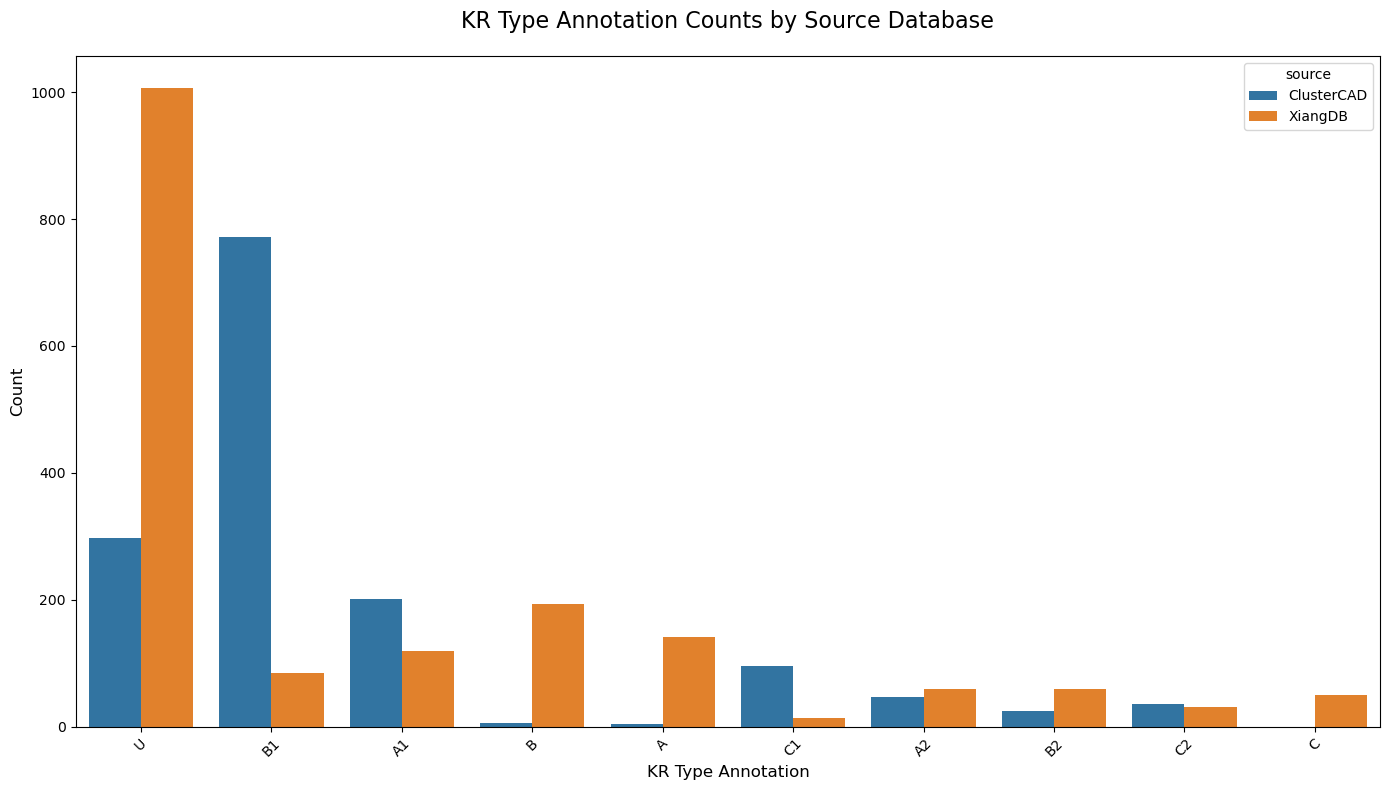


Crosstab of KR Type Counts by Source:
source              ClusterCAD  XiangDB
kr_type_annotation                     
A                            4      142
A1                         201      120
A2                          47       60
B                            6      194
B1                         771       84
B2                          24       60
C                            0       50
C1                          95       13
C2                          36       31
U                          297     1007
------------------------------------------------------------


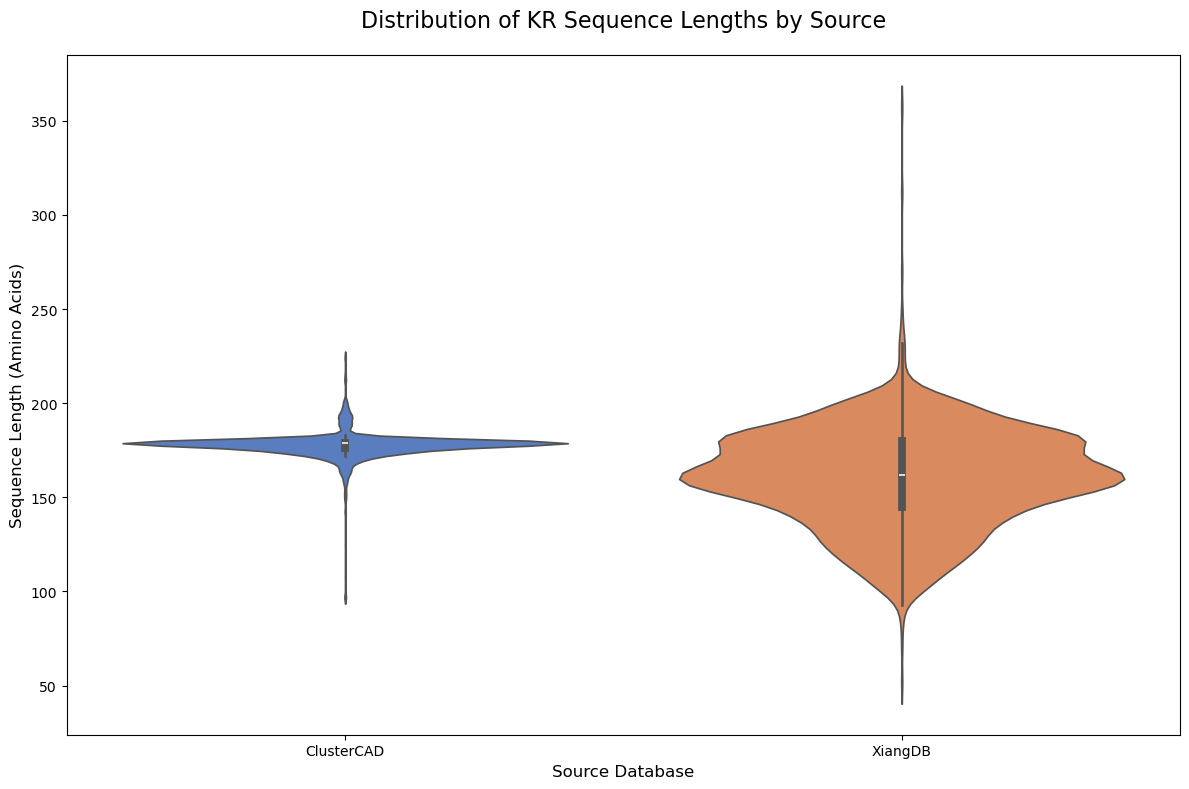

✅ Comparative plots generated.
------------------------------------------------------------

--- Generating Plots for the Combined Dataset ---


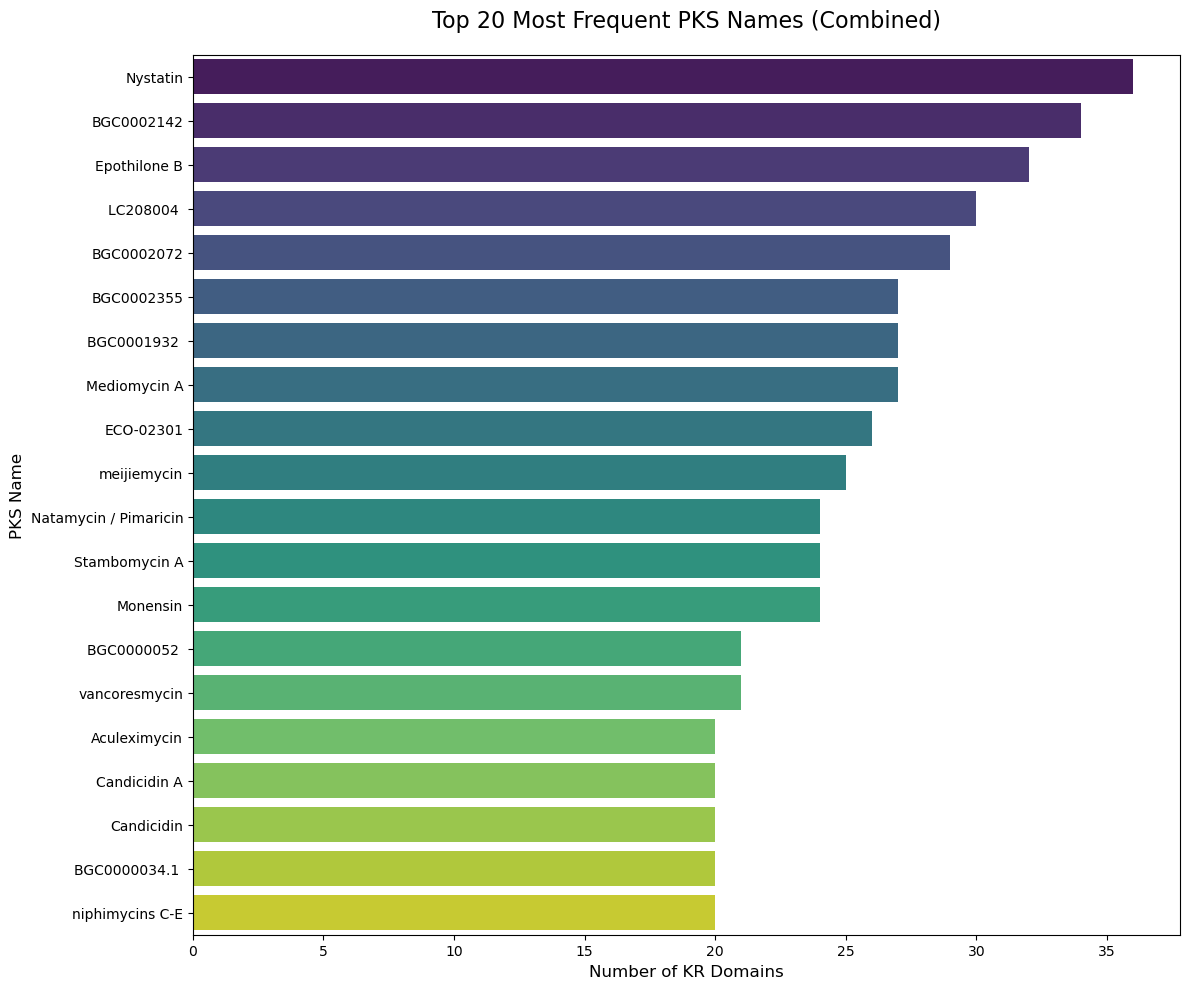

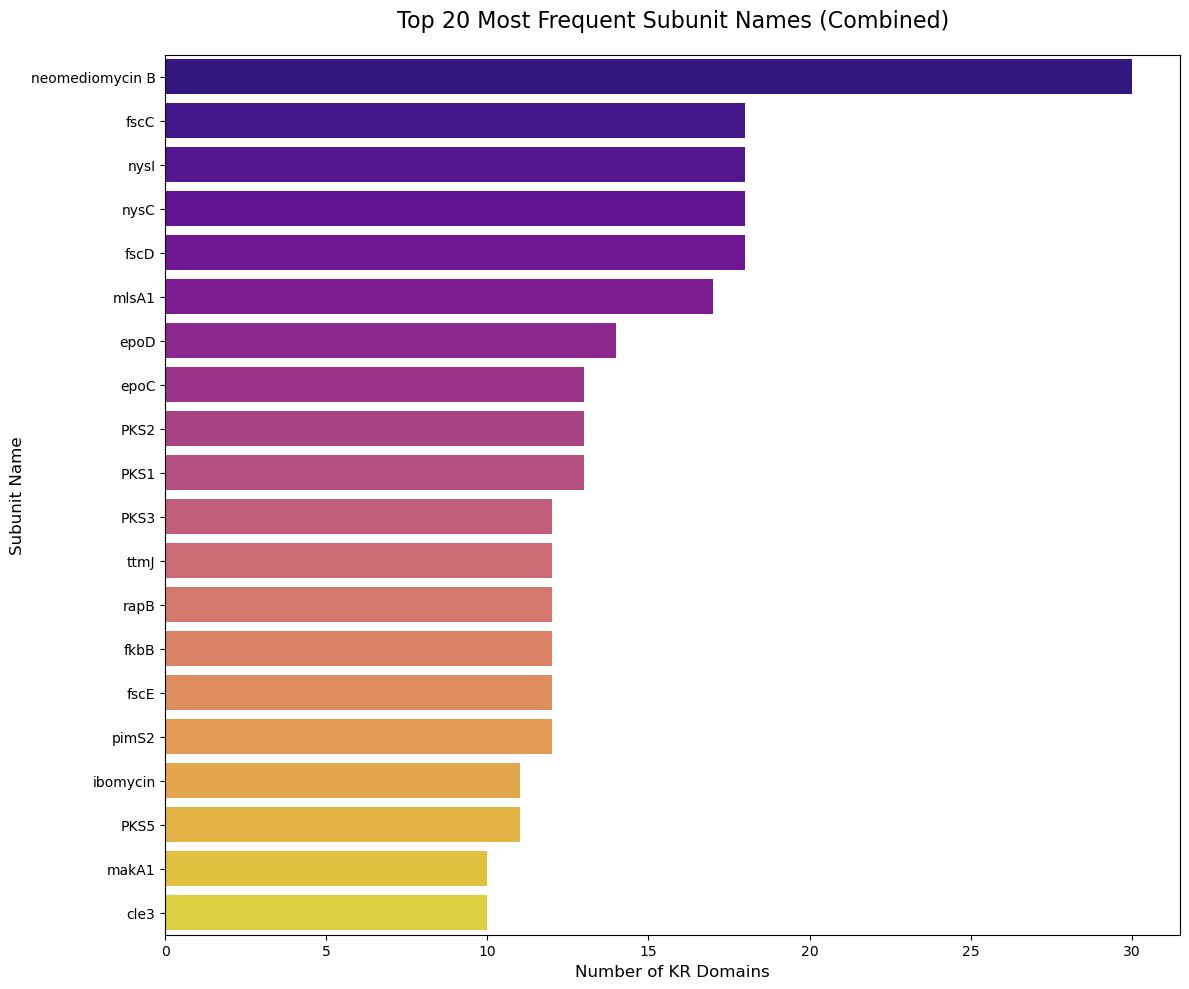

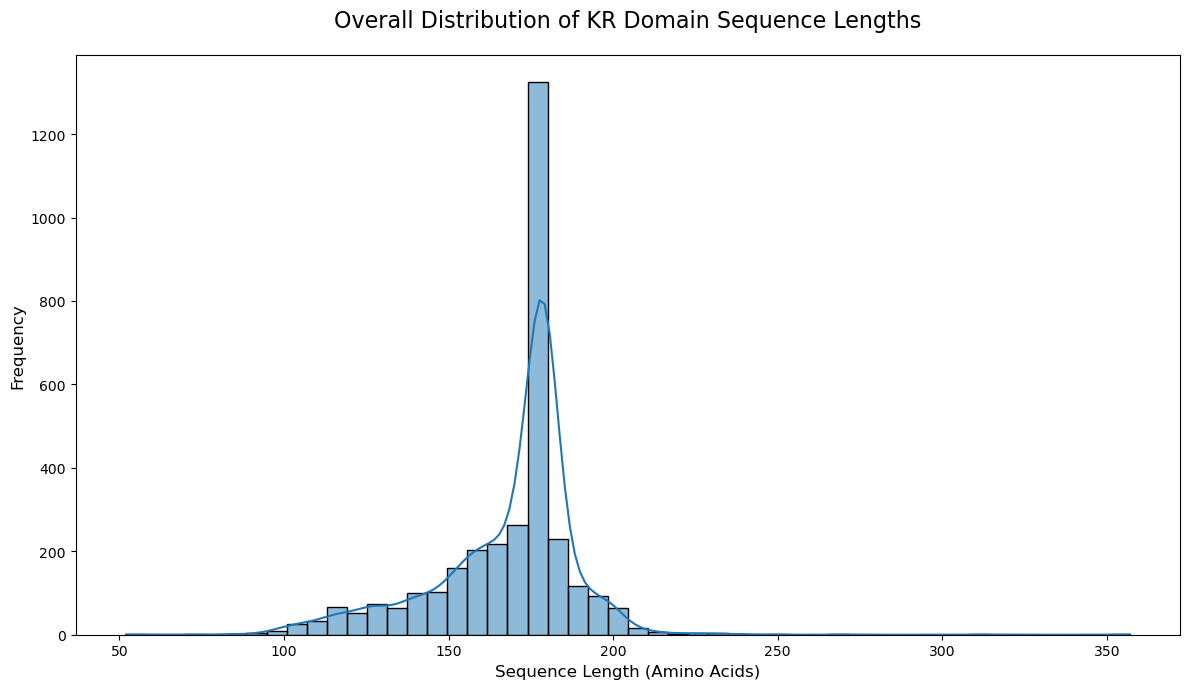

✅ Combined dataset plots generated.
------------------------------------------------------------
🎉 All EDA plots have been saved to 'eda_merged_db_figures/merged_db_analysis.pdf' and as individual PNGs in the 'eda_merged_db_figures' directory.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.backends.backend_pdf import PdfPages
import warnings

# --- 1. SETUP & DATA PREPARATION ---

# Suppress warnings from matplotlib/seaborn for cleaner output
warnings.filterwarnings("ignore")

# Define the directory to save figures
output_dir = 'eda_merged_db_figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: '{output_dir}'")

# Load the merged dataframe
input_file = 'db_merged.csv'
try:
    df = pd.read_csv(input_file)
except FileNotFoundError:
    print(f"Error: The merged file '{input_file}' was not found.")
    print("Please make sure you have run the merging script first.")
    exit()

# Data cleaning and feature engineering
df.dropna(subset=['kr_sequence'], inplace=True)
df['kr_sequence_length'] = df['kr_sequence'].apply(len)

figures = []
print(f"\nLoaded {len(df)} total KR domains for analysis from '{input_file}'.")
print("-" * 60)


# --- 2. COMPARATIVE ANALYSIS: ClusterCAD vs. XiangDB ---

print("--- Generating Comparative Plots (ClusterCAD vs. XiangDB) ---")

# Plot 1: KR Type Distribution by Source Database (Core Request)
fig1, ax1 = plt.subplots(figsize=(14, 8))
sns.countplot(
    data=df,
    x='kr_type_annotation',
    hue='source',
    order=df['kr_type_annotation'].value_counts().index,
    ax=ax1
)
ax1.set_title('KR Type Annotation Counts by Source Database', fontsize=16, pad=20)
ax1.set_xlabel('KR Type Annotation', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
figures.append(fig1)
plt.savefig(os.path.join(output_dir, '01_kr_types_by_source.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the exact numbers for clarity
print("\nCrosstab of KR Type Counts by Source:")
print(pd.crosstab(df['kr_type_annotation'], df['source']))
print("-" * 60)

# Plot 2: Sequence Length Distribution by Source
fig2, ax2 = plt.subplots(figsize=(12, 8))
sns.violinplot(
    data=df,
    x='source',
    y='kr_sequence_length',
    ax=ax2,
    palette='muted'
)
ax2.set_title('Distribution of KR Sequence Lengths by Source', fontsize=16, pad=20)
ax2.set_xlabel('Source Database', fontsize=12)
ax2.set_ylabel('Sequence Length (Amino Acids)', fontsize=12)
plt.tight_layout()
figures.append(fig2)
plt.savefig(os.path.join(output_dir, '02_seq_length_by_source.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✅ Comparative plots generated.")
print("-" * 60)


# --- 3. ANALYSIS OF COMBINED DATABASE ---

print("\n--- Generating Plots for the Combined Dataset ---")
top_n = 20 # Number of top items to show in plots

# Plot 3: Overall Top PKS Names
# Drop NA values from pks_name column before counting
top_pks = df['pks_name'].dropna().value_counts().nlargest(top_n)
fig3, ax3 = plt.subplots(figsize=(12, 10))
sns.barplot(y=top_pks.index, x=top_pks.values, palette='viridis', ax=ax3)
ax3.set_title(f'Top {top_n} Most Frequent PKS Names (Combined)', fontsize=16, pad=20)
ax3.set_xlabel('Number of KR Domains', fontsize=12)
ax3.set_ylabel('PKS Name', fontsize=12)
plt.tight_layout()
figures.append(fig3)
plt.savefig(os.path.join(output_dir, '03_top_pks_names_combined.png'), dpi=150, bbox_inches='tight')
plt.show()

# Plot 4: Overall Top Subunit Names
top_subunits = df['subunit_name'].dropna().value_counts().nlargest(top_n)
fig4, ax4 = plt.subplots(figsize=(12, 10))
sns.barplot(y=top_subunits.index, x=top_subunits.values, palette='plasma', ax=ax4)
ax4.set_title(f'Top {top_n} Most Frequent Subunit Names (Combined)', fontsize=16, pad=20)
ax4.set_xlabel('Number of KR Domains', fontsize=12)
ax4.set_ylabel('Subunit Name', fontsize=12)
plt.tight_layout()
figures.append(fig4)
plt.savefig(os.path.join(output_dir, '04_top_subunit_names_combined.png'), dpi=150, bbox_inches='tight')
plt.show()

# Plot 5: Overall Sequence Length Histogram
fig5, ax5 = plt.subplots(figsize=(12, 7))
sns.histplot(df['kr_sequence_length'], kde=True, ax=ax5, bins=50)
ax5.set_title('Overall Distribution of KR Domain Sequence Lengths', fontsize=16, pad=20)
ax5.set_xlabel('Sequence Length (Amino Acids)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
figures.append(fig5)
plt.savefig(os.path.join(output_dir, '05_seq_length_histogram_combined.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Combined dataset plots generated.")
print("-" * 60)


# --- 4. SAVE ALL FIGURES TO A SINGLE PDF ---
pdf_path = os.path.join(output_dir, 'merged_db_analysis.pdf')
with PdfPages(pdf_path) as pdf:
    # Reverse list to save in a more logical order (comparison first)
    for fig in reversed(figures):
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig) # Close the figure to free up memory

print(f"🎉 All EDA plots have been saved to '{pdf_path}' and as individual PNGs in the '{output_dir}' directory.")